# Ficha de trabalho - Clustering e redução dimensionalidade
Ficheiros a usar: 
* wines.csv - ficheiro com os dados das análises
* wines_labels.csv - labels das classes


**Sumário:**

A data frame containing 177 rows and thirteen columns. These data are the results of chemical analyses of wines grown in the same region in Italy (Piedmont) but derived from three different cultivars (classes).


In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage

1 - Importa os dados presentes nos dois ficheiros.

In [2]:
meta = pd.read_csv("wines_labels.csv")
data = pd.read_csv("wines.csv")

2 - Explora o dataset, indicando:
 * o número de amostras e atributos, 
 * tipos de dados, 
 * se há valores em falta.

In [15]:
print(data.shape)
print(meta.shape)
print(data.index)
print ([data.iloc[:,i].dtype for i in range(data.shape[1])])
data.isnull().sum()
print(data.head())
print(meta.head())

(177, 14)
(177, 2)
RangeIndex(start=0, stop=177, step=1)
[dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64')]
   Unnamed: 0  alcohol  malic acid   ash  ash alkalinity  magnesium  \
0           1    13.20        1.78  2.14            11.2        100   
1           2    13.16        2.36  2.67            18.6        101   
2           3    14.37        1.95  2.50            16.8        113   
3           4    13.24        2.59  2.87            21.0        118   
4           5    14.20        1.76  2.45            15.2        112   

   tot. phenols  flavonoids  non-flav. phenols  proanth  col. int.  col. hue  \
0          2.65        2.76               0.26     1.28       4.38      1.05   
1          2.80        3.24               0.30     2.81       5.68      1.03   
2          3.85        3.49  

3 - Verifica se as amostras provenientes das classes "Barolo" e "Barbera" têm níveis de alcool significativamente diferentes. 

In [18]:
barolo = data[meta["x"]=="Barolo"]["alcohol"]
barbera = data[meta["x"]=="Barbera"]["alcohol"]

# h0 dados seguem uma distribuição normal
print(stats.shapiro(barolo))
print(stats.shapiro(barbera))
# aceitamos a hipotese nula em como os dados seguem uma distribuição normal

# h0 diferença das medias é igual a 0
print(stats.ttest_ind(barbera,barolo))
# regeitamos a hipotese nula e assumimos que existem diferenças nas medias


ShapiroResult(statistic=0.981652021408081, pvalue=0.5255285501480103)
ShapiroResult(statistic=0.981467604637146, pvalue=0.6408376097679138)
Ttest_indResult(statistic=-6.046516305087218, pvalue=2.3479977832012858e-08)


4 - Efectua uma análise semelhante à anterior mas considerando também a classe “Grignolino”. 

In [19]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi


mydata = data.join(meta['x'])
lm = ols("mydata.alcohol~mydata.x", mydata).fit()

print (anova_lm(lm))
# reject HO :  p_value <0.05


mcDate = multi.MultiComparison(mydata.alcohol,mydata.x)
Results = mcDate.tukeyhsd()
print(Results)

             df     sum_sq    mean_sq           F        PR(>F)
mydata.x    2.0  69.514462  34.757231  132.569148  1.050680e-35
Residual  174.0  45.619651   0.262182         NaN           NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2   meandiff p-adj  lower   upper  reject
--------------------------------------------------------
Barbera     Barolo   0.5826   0.0  0.3464  0.8188   True
Barbera Grignolino   -0.875  -0.0 -1.1012 -0.6488   True
 Barolo Grignolino  -1.4576  -0.0 -1.6719 -1.2434   True
--------------------------------------------------------


5 - Realiza um PCA e determine quantos componentes principais são necessários para explicar 90% da variabilidade dos dados. Representa os scores num gráfico onde as cores dos pontos variam consoante a classe a que a amostra pertence. O que conclui em relação à discriminação das respetivas classes?

[0.38907109 0.17866953 0.10447868 0.07027314 0.0626067  0.04836858
 0.03956637 0.02506984 0.02085772 0.01784655 0.01623083 0.01221288
 0.00872079]


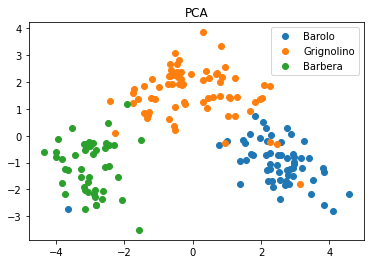

In [20]:
from sklearn.decomposition import PCA
data_scaled= preprocessing.scale(data)
n=13
pca = PCA(n_components=n)
pca.fit(data_scaled)
x_reduced = pca.transform(data_scaled)

print (pca.explained_variance_ratio_) 

for casta in meta.x.unique():
    index_samples = meta.index[meta.x==casta]-1 # -1 porque a indexação dos arrays começa em 0 e as labels do atributo index no dataframe começa em 1.
    plt.plot(x_reduced[index_samples,0],x_reduced[index_samples,1], 'o' , label=casta)
plt.title("PCA")
plt.legend(loc='best', shadow=False)
plt.show()

6 - Realizar clustering hierarquico dos dados, utilizando a métrica de distância "Manhattan”. Apresenta a àrvore resultante colorindo as folas de acordo com a classe. O que conclui olhando para os resultados?


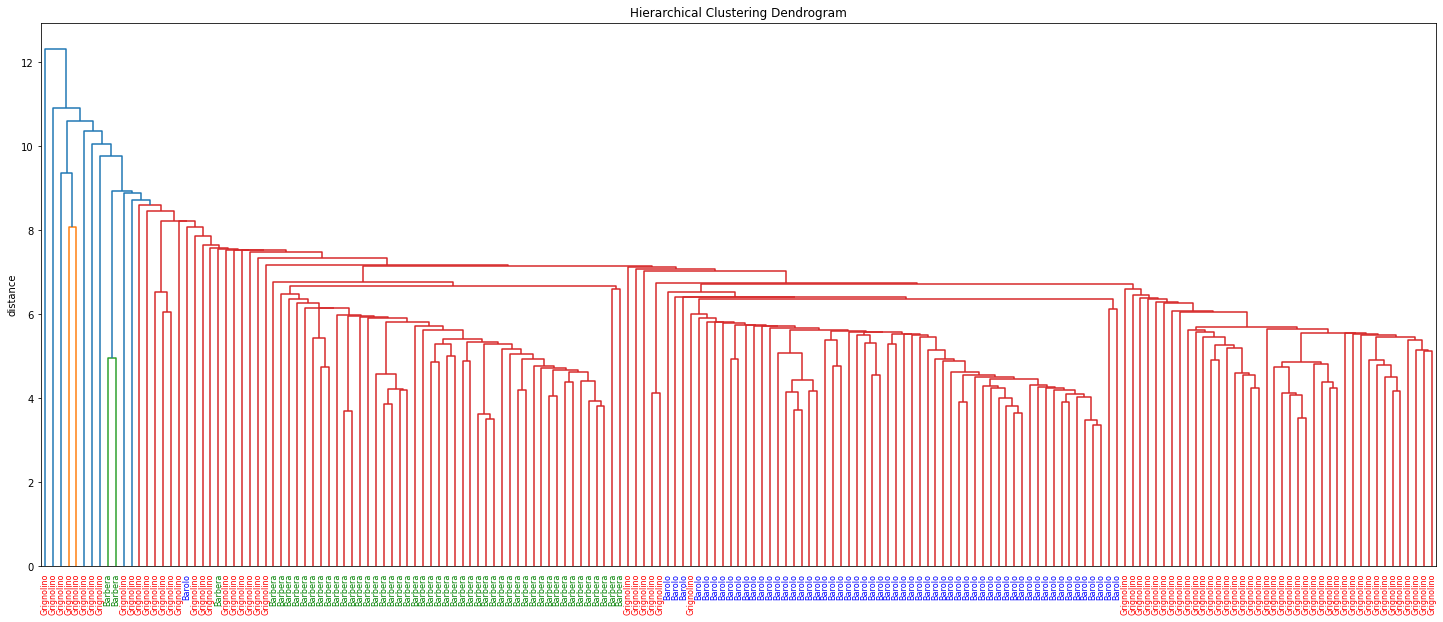

In [21]:
Z = linkage(data_scaled, metric='cityblock')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(meta['x']),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('distance')

# Assignment of colors to labels: 'a' is red, 'b' is green, etc.
label_colors = {'Barolo': 'b', 'Grignolino': 'r', 'Barbera': 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

7 - Aplica a função de clustering k-means aos dados, com k =3, e compara os resultados com os presentes na variavel *wines_labels*. O que conclui desta análise? Cruze os resultados com os obtidos anteriormente.

In [22]:
from sklearn.cluster import KMeans

k=3
kmeans = KMeans(n_clusters=k, max_iter=1000)
kmeans.fit(data_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

pd.crosstab(labels, meta["x"], rownames=['clusters'] )

x,Barbera,Barolo,Grignolino
clusters,,,
0,0,58,2
1,48,0,2
2,0,0,67
